# ECG classification

Laurent Cetinsoy - Datadidacte


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy

import matplotlib.pyplot as plt
from IPython.display import HTML

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

import pywt

## A first naive model by extracting simple features


Your environment contains variables arr, nsr, and chf which respectively contain 10-second recordings of ECG signals extracted from three datasets on PhysioNet: one from a person suffering from arrhythmia, one from a person with a normal heart rhythm, and another from a person with heart failure.


Matplotlib  subplots (or any other library), display these signals on three subfigures (the subplots should be called with the parameter nrows = 3).
Can you find any differences between them?

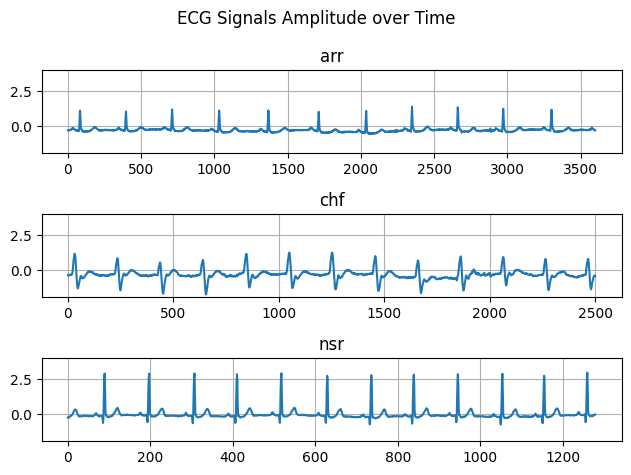

In [2]:
arr = np.loadtxt('/kaggle/input/ecg-dataset/arr.txt')
chf = np.loadtxt('/kaggle/input/ecg-dataset/chf.txt')
nsr = np.loadtxt('/kaggle/input/ecg-dataset/nsr.txt')

data = [arr, chf, nsr]
titles = ['arr', 'chf', 'nsr']

fig, axs = plt.subplots(nrows=3)
fig.suptitle('ECG Signals Amplitude over Time')

for i, ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.plot(data[i])
    ax.set_ylim(-2, 4)
    ax.grid()

plt.tight_layout()
plt.show()

We want to extract features from the time series. For that we will use simple statistics.


Create a function named calculate_stats_features(x) that calculates some statistical features of a signal x using standard numpy functions: nanpercentile, nanmean, etc.
calculate_stats_features will return a list of features in this order:

0. Max
1. Min
2. Mean
3. Median
4. Variance

In [3]:
def calculate_stats_features(x):
  x = np.array(x)
  return np.max(x),  np.min(x), np.mean(x), np.median(x), np.var(x)

print(calculate_stats_features(arr))
print(calculate_stats_features(chf))
print(calculate_stats_features(nsr))

(1.375, -0.59, -0.3120111111111112, -0.335, 0.039663552654320984)
(1.235, -1.79, -0.363622, -0.375, 0.15541165111599997)
(2.965, -0.785, -0.035453124999999995, -0.145, 0.21755463842773434)




Create a function named `calculate_zero_crossing(x)` that calculates the Zero
Crossing of a signal x.

The zero crossing is defined as the number of times the signal changes sign.
For this, you can use the signbit, diff, and nonzero functions from numpy.


In [4]:
def calculate_zero_crossing(x):
  return len(np.diff(np.signbit(x)).nonzero()[0])

print(calculate_zero_crossing(arr))
print(calculate_zero_crossing(chf))
print(calculate_zero_crossing(nsr))

22
28
66


Create a function named **calculate_rms(x)** that returns the Root Mean Square (RMS) of a signal x. We will use the nanmean function instead of the mean function from numpy.

In [5]:
def calculate_rms(x):
  x = np.array(x, dtype=float)
  return np.sqrt(np.nanmean(x**2))

print(calculate_rms(arr))
print(calculate_rms(chf))
print(calculate_rms(nsr))

0.37015467862923346
0.5363139099445399
0.46777298179779475


Create a function named calculate_entropy(x) that calculates the Shannon entropy of a signal x using the entropy function from scipy.stats.

In [6]:
def calculate_entropy(x):
  count = np.unique(x, return_counts=True)[1]
  prob = count / len(x)
  base = 2
  return entropy(prob, base=base)

print(calculate_entropy(arr))
print(calculate_entropy(chf))
print(calculate_entropy(nsr))

6.412131172801207
7.643477555491811
5.7127244365249705


Create a function get_features(x) that combines the features calculated by all previous functions including caculate_stats_features.

In [7]:
def get_features(x):
  return [*calculate_stats_features(x), calculate_zero_crossing(x), calculate_rms(x), calculate_entropy(x)]

print(get_features(arr))
print(get_features(chf))
print(get_features(nsr))

[1.375, -0.59, -0.3120111111111112, -0.335, 0.039663552654320984, 22, 0.37015467862923346, 6.412131172801207]
[1.235, -1.79, -0.363622, -0.375, 0.15541165111599997, 28, 0.5363139099445399, 7.643477555491811]
[2.965, -0.785, -0.035453124999999995, -0.145, 0.21755463842773434, 66, 0.46777298179779475, 5.7127244365249705]


Load the small ecg dataset
Use your fonction get_features create a new dataframe where you have all the feature as X and y as the label.
Train a random forest on it after doing a train test split if the dataset is not too small

In [8]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    
    train_loss = log_loss(y_train, y_train_pred_proba, labels=model.classes_)
    test_loss = log_loss(y_test, y_test_pred_proba, labels=model.classes_)
    
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    metrics = {
        "train_loss": train_loss,
        "test_loss": test_loss,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
    }

    print("----- Model Results -----")
    print(f"Training Accuracy: {metrics['train_accuracy']:.2f}")
    print(f"Testing Accuracy: {metrics['test_accuracy']:.2f}")
    print(f"Training Loss (Log Loss): {metrics['train_loss']:.2f}")
    print(f"Testing Loss (Log Loss): {metrics['test_loss']:.2f}")
    print("-------------------------")

    return metrics

In [9]:
# ---------------------------- Feature Extraction ----------------------------
ecg_data = pd.read_csv('/kaggle/input/ecg-dataset/ecg_small_dataset.csv')

labels = ecg_data['1']
ecg_data = ecg_data.drop(columns=['0', '1'])

ecg_data['features'] = ecg_data.apply(lambda row: get_features(row), axis=1)
features = ecg_data['features']

final_dataset = pd.concat([features, labels.reset_index(drop=True)], axis=1)
final_dataset.columns = ['X', 'y']

X = pd.DataFrame(final_dataset['X'].to_list())
y = final_dataset['y']

display(final_dataset)

# ---------------------------- Model Training & Evaluation ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

metrics_features = evaluate_model(classifier, X_train, X_test, y_train, y_test)

,X,y
0,"[1.002117573015905, -0.5927308072482946, -0.34...",1
1,"[-0.2815212090436512, -0.923733716922188, -0.5...",1
2,"[1.2357491788849733, -2.492696518919409, -0.34...",2
3,"[1.2954938604802426, -3.1054546307069795, -0.1...",2
4,"[2.444999999999999, -1.005, -0.046348632812499...",0
5,"[1.6449999999999998, -1.2649999999999997, -0.0...",0


----- Model Results -----
Training Accuracy: 1.00
Testing Accuracy: 0.00
Training Loss (Log Loss): 0.14
Testing Loss (Log Loss): 1.10
-------------------------


Now you have a first pipeline, do the same on the full dataset
Report the train and test loss

In [10]:
# ---------------------------- Feature Extraction ----------------------------
ecg_data = pd.read_csv('/kaggle/input/ecg-dataset/ECG_classification_full_dataset/ECG-laurent.csv', dtype={'0': str})

labels = ecg_data['1']
ecg_data = ecg_data.drop(columns=['0', '1'])

ecg_data['features'] = ecg_data.apply(lambda row: get_features(row), axis=1)
features = ecg_data['features']

final_dataset = pd.concat([features, labels.reset_index(drop=True)], axis=1)
final_dataset.columns = ['X', 'y']

X = pd.DataFrame(final_dataset['X'].to_list())
y = final_dataset['y']

display(final_dataset)

# ---------------------------- Model Training & Evaluation ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

metrics_features = evaluate_model(classifier, X_train, X_test, y_train, y_test)

,X,y
0,"[3.006142707306705, -2.4609111856787296, -0.26...",1
1,"[2.527708284838204, -3.5506973594845337, -0.22...",1
2,"[2.264554782554512, -3.929179042915948, -0.163...",1
3,"[3.0554208647023837, -1.906981631021488, 0.053...",1
4,"[2.03500145120734, -1.5751974689082626, -0.148...",1
...,...,...
157,"[0.6358373559094106, -2.0365926567259875, -0.2...",2
158,"[2.777682603099887, -1.4084656550450647, -0.27...",2
159,"[0.9198938935248732, -1.070184753597739, -0.17...",2
160,"[7.078176793392733, -5.961910389666239, -0.343...",2


----- Model Results -----
Training Accuracy: 0.84
Testing Accuracy: 0.85
Training Loss (Log Loss): 0.43
Testing Loss (Log Loss): 0.48
-------------------------


try to tweak the model hyperparameter to see if it works

In [11]:
param_grid = {
    'max_depth': range(1, 11),
    'n_estimators': [50, 100, 200],
    'min_samples_split': [2, 5, 10]
}

classifier = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)


grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print('Best parameters:', best_params)
metrics_features_tuned = evaluate_model(best_model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 50}
----- Model Results -----
Training Accuracy: 0.98
Testing Accuracy: 0.91
Training Loss (Log Loss): 0.15
Testing Loss (Log Loss): 0.25
-------------------------


## Fourier transform features

We want now to see if a model using only fourier transform could work.

create a function get_fourier_coefficients(ecg)

In [12]:
def get_fourier_coefficients(ecg):
  return np.absolute(np.fft.fft(ecg))

print(get_fourier_coefficients(arr))
print(get_fourier_coefficients(chf))
print(get_fourier_coefficients(nsr))

[1123.24         89.20615882   41.4694965  ...   36.49238077   41.4694965
   89.20615882]
[909.055       44.7602003   97.55499805 ...  80.09173453  97.55499805
  44.7602003 ]
[45.38       17.7158196   3.64890393 ... 17.53068156  3.64890393
 17.7158196 ]


Using this function create a dataframe df_fourrier containing the fourrier transform coefficients and the label

In [13]:
ecg_data = pd.read_csv('/kaggle/input/ecg-dataset/ECG_classification_full_dataset/ECG-laurent.csv', dtype={'0': str})

labels = ecg_data['1']
ecg_data = ecg_data.drop(columns=['0', '1'])

ecg_data['features'] = ecg_data.apply(lambda row: get_fourier_coefficients(row), axis=1)

df_fourier = pd.concat([ecg_data[['features']], labels.reset_index(drop=True)], axis=1)
df_fourier.columns = ['X', 'y']

X = pd.DataFrame(df_fourier['X'].to_list())
y = df_fourier['y']

display(df_fourier)

,X,y
0,"[17599.976888888887, 1850.1715668192646, 295.3...",1
1,"[14484.396444444446, 4137.499333507482, 2152.3...",1
2,"[10683.818666666666, 400.46346141192544, 481.5...",1
3,"[3536.4622222222224, 313.20486632601256, 531.5...",1
4,"[9756.496, 303.3299454878462, 596.020424218000...",1
...,...,...
157,"[14269.954559999998, 593.4128358681398, 760.98...",2
158,"[17730.076160000004, 378.72137224537425, 408.4...",2
159,"[11277.319679999999, 1434.1967613702957, 2603....",2
160,"[22526.704639999996, 289.587562932029, 621.209...",2


Try to train a model using the Fourrier coefficient

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

metrics_fourier = evaluate_model(classifier, X_train, X_test, y_train, y_test)

----- Model Results -----
Training Accuracy: 0.83
Testing Accuracy: 0.70
Training Loss (Log Loss): 0.43
Testing Loss (Log Loss): 0.68
-------------------------


Try to learn a model using both fourrier coefficient and the features from the previous sections. Does it work ?

In [15]:
def get_features_and_fourier_coefficients(x):
  return [*get_features(x), *get_fourier_coefficients(x)]

In [16]:
# ---------------------------- Feature Extraction ----------------------------
ecg_data = pd.read_csv('/kaggle/input/ecg-dataset/ECG_classification_full_dataset/ECG-laurent.csv', dtype={'0': str})

labels = ecg_data['1']
ecg_data = ecg_data.drop(columns=['0', '1'])

ecg_data['features'] = ecg_data.apply(lambda row: get_features_and_fourier_coefficients(row), axis=1)
features = ecg_data['features']

final_dataset = pd.concat([features, labels.reset_index(drop=True)], axis=1)
final_dataset.columns = ['X', 'y']

X = pd.DataFrame(final_dataset['X'].to_list())
y = final_dataset['y']

display(final_dataset)

# ---------------------------- Model Training & Evaluation ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

metrics_features_and_fourier = evaluate_model(classifier, X_train, X_test, y_train, y_test)

,X,y
0,"[3.006142707306705, -2.4609111856787296, -0.26...",1
1,"[2.527708284838204, -3.5506973594845337, -0.22...",1
2,"[2.264554782554512, -3.929179042915948, -0.163...",1
3,"[3.0554208647023837, -1.906981631021488, 0.053...",1
4,"[2.03500145120734, -1.5751974689082626, -0.148...",1
...,...,...
157,"[0.6358373559094106, -2.0365926567259875, -0.2...",2
158,"[2.777682603099887, -1.4084656550450647, -0.27...",2
159,"[0.9198938935248732, -1.070184753597739, -0.17...",2
160,"[7.078176793392733, -5.961910389666239, -0.343...",2


----- Model Results -----
Training Accuracy: 0.81
Testing Accuracy: 0.70
Training Loss (Log Loss): 0.44
Testing Loss (Log Loss): 0.68
-------------------------


The model seems to work, but it performs poorly compared to the version trained without Fourier coefficients.

## Wavelets

We now wants to use another signal decomposition which are called wavelet. Wavelet are a multi-scale function decomposition on a familly of functions generated from what is called a mother wavelet.

Using PyWavelet make a function get_wavelet_coefficients(ecg) that returns the wavelet coefficient of a given ECG


In [17]:
def get_wavelet_coefficients(ecg):
  coeffs = pywt.wavedec(ecg, 'db4', level=4)
  return np.concatenate(coeffs)

print(get_wavelet_coefficients(arr))
print(get_wavelet_coefficients(chf))
print(get_wavelet_coefficients(nsr))

[-1.37958911 -1.38013618 -1.37995439 ... -0.00284855 -0.00600039
 -0.00399507]
[-1.64539423e+00 -1.65561758e+00 -1.64863113e+00 ...  5.63579040e-03
  1.58442129e-02 -6.35462182e-04]
[-1.03166109 -1.03206469 -1.03149483 ... -0.00636377 -0.02045891
 -0.00122713]


Using the get_wavelet_coefficients, create a dataframe when the features are the coefficients and include the label

In [18]:
# ---------------------------- Feature Extraction ----------------------------
ecg_data = pd.read_csv('/kaggle/input/ecg-dataset/ECG_classification_full_dataset/ECG-laurent.csv', dtype={'0': str})

labels = ecg_data['1']
ecg_data = ecg_data.drop(columns=['0', '1'])

ecg_data['features'] = ecg_data.apply(lambda row: get_wavelet_coefficients(row), axis=1)
features = ecg_data['features']

final_dataset = pd.concat([features, labels.reset_index(drop=True)], axis=1)
final_dataset.columns = ['X', 'y']

X = pd.DataFrame(final_dataset['X'].to_list())
y = final_dataset['y']

display(final_dataset)

,X,y
0,"[-0.22873970202284766, -0.1900082410717739, -0...",1
1,"[-2.2842914503698513, -2.31178130833542, -2.29...",1
2,"[-0.82186266690483, -0.7960119467060363, -0.77...",1
3,"[0.3489256596734519, 0.37519779000686654, 0.37...",1
4,"[-1.6430631702701892, -1.6667650545155035, -1....",1
...,...,...
157,"[-1.2564112361726547, -1.1760855167700797, -1....",2
158,"[-1.5471528539406083, -1.5586704962114701, -1....",2
159,"[-0.36592131342095724, -0.35716230147652883, -...",2
160,"[0.7311748033721763, 0.7859117213111128, 0.819...",2


Train a random forest classifier with such features. DOes the model work

In [19]:
# ---------------------------- Model Training & Evaluation ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

metrics_wavelet = evaluate_model(classifier, X_train, X_test, y_train, y_test)

----- Model Results -----
Training Accuracy: 0.74
Testing Accuracy: 0.58
Training Loss (Log Loss): 0.58
Testing Loss (Log Loss): 0.89
-------------------------


The model doesn't perform well on the test set

Add one or several of the previous feature functions and try to train another model

In [20]:
def get_all_features(x):
  return [*get_features(x), *get_fourier_coefficients(x), *get_wavelet_coefficients(x)]

In [21]:
# ---------------------------- Feature Extraction ----------------------------
ecg_data = pd.read_csv('/kaggle/input/ecg-dataset/ECG_classification_full_dataset/ECG-laurent.csv', dtype={'0': str})

labels = ecg_data['1']
ecg_data = ecg_data.drop(columns=['0', '1'])

ecg_data['features'] = ecg_data.apply(lambda row: get_all_features(row), axis=1)
features = ecg_data['features']

final_dataset = pd.concat([features, labels.reset_index(drop=True)], axis=1)
final_dataset.columns = ['X', 'y']

X = pd.DataFrame(final_dataset['X'].to_list())
y = final_dataset['y']

display(final_dataset)

# ---------------------------- Model Training & Evaluation ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

metrics_mixed = evaluate_model(classifier, X_train, X_test, y_train, y_test)

,X,y
0,"[3.006142707306705, -2.4609111856787296, -0.26...",1
1,"[2.527708284838204, -3.5506973594845337, -0.22...",1
2,"[2.264554782554512, -3.929179042915948, -0.163...",1
3,"[3.0554208647023837, -1.906981631021488, 0.053...",1
4,"[2.03500145120734, -1.5751974689082626, -0.148...",1
...,...,...
157,"[0.6358373559094106, -2.0365926567259875, -0.2...",2
158,"[2.777682603099887, -1.4084656550450647, -0.27...",2
159,"[0.9198938935248732, -1.070184753597739, -0.17...",2
160,"[7.078176793392733, -5.961910389666239, -0.343...",2


----- Model Results -----
Training Accuracy: 0.81
Testing Accuracy: 0.73
Training Loss (Log Loss): 0.43
Testing Loss (Log Loss): 0.67
-------------------------


In [22]:
param_grid = {
    'max_depth': range(1, 11),
    'n_estimators': [50, 100, 200],
    'min_samples_split': [2, 5, 10]
}

classifier = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)


grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print('Best parameters:', best_params)
metrics_mixed_tuned = evaluate_model(best_model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
----- Model Results -----
Training Accuracy: 1.00
Testing Accuracy: 0.73
Training Loss (Log Loss): 0.18
Testing Loss (Log Loss): 0.60
-------------------------


In [23]:
metrics_list = [
    ("Random Forest trained with initial features", metrics_features),
    ("Random Forest trained with initial features (hyperparameter tuning)", metrics_features_tuned),
    ("Random Forest trained with fourier coefficients", metrics_fourier),
    ("Random Forest trained with fourier coefficients and features", metrics_features_and_fourier),
    ("Random Forest trained with wavelet", metrics_wavelet),
    ("Random Forest trained with mixed features", metrics_mixed),
    ("Random Forest trained with mixed features (hyperparameter tuning)", metrics_mixed_tuned)
]

metrics_df = pd.DataFrame(
    [
        {
            "Model": name,
            "Train Loss": metrics["train_loss"],
            "Test Loss": metrics["test_loss"],
            "Train Accuracy": metrics["train_accuracy"],
            "Test Accuracy": metrics["test_accuracy"],
        }
        for name, metrics in metrics_list
    ]
)

display(metrics_df)

,Model,Train Loss,Test Loss,Train Accuracy,Test Accuracy
0,Random Forest trained with initial features,0.429314,0.480338,0.844961,0.848485
1,Random Forest trained with initial features (h...,0.152651,0.247454,0.976744,0.909091
2,Random Forest trained with fourier coefficients,0.428839,0.681887,0.829457,0.696970
3,Random Forest trained with fourier coefficient...,0.435776,0.675956,0.813953,0.696970
4,Random Forest trained with wavelet,0.583714,0.891466,0.736434,0.575758
5,Random Forest trained with mixed features,0.430331,0.670148,0.813953,0.727273
6,Random Forest trained with mixed features (hyp...,0.179270,0.603174,1.000000,0.727273


Specify the methodology you used to train the model and report the various attempts results into a table

- For the last model, I included all the previous feature and did a grid search for hyperparameter tuning

## Deep learning (1D CNN)

Now we want to see if we can skip all theses feature engineering techniques !
Design and train a multi-layer one dimensional CNN using the raw ECG signal as features.


Could you reach or surpass the feature based models ?

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

data = pd.read_csv('/kaggle/input/ecg-dataset/ECG_classification_full_dataset/ECG-laurent.csv', dtype={'0': str})
y = data.iloc[:, 1].astype(int)
X = data.iloc[:, 2:].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


model = Sequential([
    Conv1D(16, kernel_size=15, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    
    Conv1D(32, kernel_size=15, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    
    Conv1D(64, kernel_size=15, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)


optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4668 - loss: 1.7125 - val_accuracy: 0.5385 - val_loss: 1.6530 - learning_rate: 0.0010
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.6090 - loss: 1.5817 - val_accuracy: 0.5385 - val_loss: 1.5763 - learning_rate: 0.0010
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.5592 - loss: 1.6135 - val_accuracy: 0.5385 - val_loss: 1.5203 - learning_rate: 0.0010
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.6137 - loss: 1.4475 - val_accuracy: 0.5385 - val_loss: 1.4633 - learning_rate: 0.0010
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.5895 - loss: 1.4591 - val_accuracy: 0.5385 - val_loss: 1.4010 - learning_rate: 0.0010
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.5973 - loss: 1.3634 - val_accuracy: 0.5385 - val_loss: 1.3422 - learning_rate: 0.0010
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.6007 - loss: 1.2773 - val_accuracy: 0.

### Conclusion

- The deep neural network trained on raw ECG data achieved a test accuracy of 0.8788, which is pretty close to the best random forest model, which reached 0.9090 when trained on features.

- This suggests that while feature engineering provides a small performance boost, the CNN can still perform well without relying on manual feature extraction.